In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
nltk.download('wordnet')
from copy import deepcopy

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1rati\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
train_df = pd.read_csv('../data/text/Twitter Sentiment Analysis/train.csv')

In [36]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [37]:
train_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [17]:
def add_to_dict(d, filename):
    with open(filename, 'r', encoding="utf8") as f:
        for line in f.readlines():
            line = line.split(' ')
            
            try:
                d[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue

In [18]:
# кажд слово это вектор. Вектора обучены на нейросети
words = dict()
add_to_dict(words, '../data/text/glove6B/glove.6b.50d.txt')

In [20]:
len(words)

400000

In [32]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize('@user when a father /is !dysfunctional and %is')

['user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In [24]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

In [46]:
def message_to_token_list(s):
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t in words]
    
    return useful_tokens

In [47]:
message_to_token_list('@user @feet a $fathers /is !dysfunctional and %is')

['user', 'foot', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In [48]:
def message_to_word_vectors(message, word_dict=words):
    processed_list_of_tokens = message_to_token_list(message)
    
    vectors = []
    
    for token in processed_list_of_tokens:
        token_vector = word_dict[token]
        vectors.append(token_vector)
        
    return np.array(vectors, dtype=float)

In [49]:
message_to_word_vectors('@user @feet a $fathers /is !dysfunctional and %is').shape

(8, 50)

In [60]:
# frac ранд выбрать часть дан-х (1 это все дан-е)
train_df = train_df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1: split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(22373, 4794, 4795)

In [51]:
def df_to_X_y(df):
    y = df['label'].to_numpy().astype(int)
    
    all_word_vector_sequences = []
    
    for message in df['tweet']:
        message_as_vector_sequense = message_to_word_vectors(message)
        
        # если нету такого слова в словаре
        if message_as_vector_sequense.shape[0] == 0:
            message_as_vector_sequense = np.zeros(shape=(1, 50))
        all_word_vector_sequences.append(message_as_vector_sequense)
        
    return all_word_vector_sequences, y

In [61]:
X_train, y_train = df_to_X_y(train_df)

In [62]:
len(X_train)

22373

In [69]:
# предложения имеют разную длину
len(X_train[0]), len(X_train[1]), len(X_train[2])

(13, 8, 7)

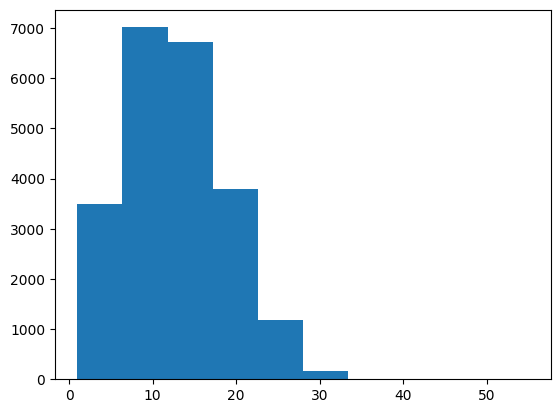

In [67]:
sequence_lengths = []

for i in range(len(X_train)):
    sequence_lengths.append(len(X_train[i]))

plt.hist(sequence_lengths);

In [68]:
pd.Series(sequence_lengths).describe()

count    22373.000000
mean        12.692308
std          5.929912
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         55.000000
dtype: float64

In [73]:
# делаем все предложения одинак длины (макс 55), добавив в кон предлож-я нули 
def pad_X(X, desired_sequence_length=57):
    X_copy = deepcopy(X)
    
    for i, x in enumerate(X):
        x_sequence_length = x.shape[0]
        sequence_length_difference = desired_sequence_length - x_sequence_length
        
        pad = np.zeros(shape=(sequence_length_difference, 50))
        
        X_copy[i] = np.concatenate([x, pad])
        
    return np.array(X_copy).astype(float)

In [74]:
X_train = pad_X(X_train)

In [75]:
X_train.shape

(22373, 57, 50)

In [78]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)
X_val.shape, y_val.shape

((4794, 57, 50), (4794,))

In [79]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)
X_test.shape, y_test.shape

((4795, 57, 50), (4795,))

In [107]:
model = Sequential([])
model.add(layers.Input(shape=(57,50)))
# return_sequences собирает стек векторов
model.add(layers.LSTM(64, return_sequences=True))
# избеж переобуч
model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(64, return_sequences=True))
# model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(64, return_sequences=True))
# model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [108]:
cp = ModelCheckpoint('../models/ltsm_twitter/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss=BinaryCrossentropy(),
             metrics=['accuracy', AUC(name='auc')])

In [109]:
frequences = pd.value_counts(train_df['label'])
frequences

0    20820
1     1553
Name: label, dtype: int64

In [110]:
# веса, чтобы в равной степени наказывать недопредставленные или перепредставленные классы
weights = {0: frequences.sum() / frequences[0], 1: frequences.sum() / frequences[1]}
weights

{0: 1.0745917387127761, 1: 14.406310367031551}

In [111]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
699/700 [============================>.] - ETA: 0s - loss: 1.0466 - accuracy: 0.7237 - auc: 0.8225

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 17s 23ms/step - loss: 1.0471 - accuracy: 0.7237 - auc: 0.8226 - val_loss: 0.5019 - val_accuracy: 0.7764 - val_auc: 0.8876
Epoch 2/20
699/700 [============================>.] - ETA: 0s - loss: 0.8159 - accuracy: 0.8151 - auc: 0.8960

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 17s 24ms/step - loss: 0.8158 - accuracy: 0.8152 - auc: 0.8960 - val_loss: 0.4231 - val_accuracy: 0.8146 - val_auc: 0.8969
Epoch 3/20
699/700 [============================>.] - ETA: 0s - loss: 0.7750 - accuracy: 0.8247 - auc: 0.9063

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 16s 23ms/step - loss: 0.7749 - accuracy: 0.8247 - auc: 0.9063 - val_loss: 0.3811 - val_accuracy: 0.8417 - val_auc: 0.9027
Epoch 4/20
700/700 [==============================] - 14s 20ms/step - loss: 0.7539 - accuracy: 0.8336 - auc: 0.9115 - val_loss: 0.4360 - val_accuracy: 0.8016 - val_auc: 0.9048
Epoch 5/20
700/700 [==============================] - 16s 23ms/step - loss: 0.7319 - accuracy: 0.8365 - auc: 0.9166 - val_loss: 0.6106 - val_accuracy: 0.7067 - val_auc: 0.9045
Epoch 6/20
698/700 [============================>.] - ETA: 0s - loss: 0.7163 - accuracy: 0.8410 - auc: 0.9201

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 17s 24ms/step - loss: 0.7161 - accuracy: 0.8411 - auc: 0.9202 - val_loss: 0.3429 - val_accuracy: 0.8504 - val_auc: 0.9112
Epoch 7/20
700/700 [==============================] - 16s 22ms/step - loss: 0.6966 - accuracy: 0.8470 - auc: 0.9245 - val_loss: 0.4836 - val_accuracy: 0.7870 - val_auc: 0.9122
Epoch 8/20
700/700 [==============================] - 15s 21ms/step - loss: 0.6790 - accuracy: 0.8514 - auc: 0.9283 - val_loss: 0.3684 - val_accuracy: 0.8377 - val_auc: 0.9135
Epoch 9/20
700/700 [==============================] - 15s 22ms/step - loss: 0.6621 - accuracy: 0.8556 - auc: 0.9320 - val_loss: 0.4819 - val_accuracy: 0.7843 - val_auc: 0.9158
Epoch 10/20
700/700 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.8534 - auc: 0.9337

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 17s 24ms/step - loss: 0.6533 - accuracy: 0.8534 - auc: 0.9337 - val_loss: 0.2952 - val_accuracy: 0.8732 - val_auc: 0.9167
Epoch 11/20
698/700 [============================>.] - ETA: 0s - loss: 0.6329 - accuracy: 0.8587 - auc: 0.9378

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 17s 25ms/step - loss: 0.6323 - accuracy: 0.8588 - auc: 0.9378 - val_loss: 0.2817 - val_accuracy: 0.8834 - val_auc: 0.9185
Epoch 12/20
700/700 [==============================] - 15s 21ms/step - loss: 0.6284 - accuracy: 0.8558 - auc: 0.9387 - val_loss: 0.3138 - val_accuracy: 0.8646 - val_auc: 0.9197
Epoch 13/20
698/700 [============================>.] - ETA: 0s - loss: 0.6090 - accuracy: 0.8576 - auc: 0.9425

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 17s 25ms/step - loss: 0.6100 - accuracy: 0.8577 - auc: 0.9423 - val_loss: 0.2791 - val_accuracy: 0.8846 - val_auc: 0.9198
Epoch 14/20
700/700 [==============================] - 16s 23ms/step - loss: 0.5967 - accuracy: 0.8639 - auc: 0.9448 - val_loss: 0.4029 - val_accuracy: 0.8141 - val_auc: 0.9207
Epoch 15/20
700/700 [==============================] - 16s 23ms/step - loss: 0.5765 - accuracy: 0.8669 - auc: 0.9482 - val_loss: 0.3781 - val_accuracy: 0.8252 - val_auc: 0.9222
Epoch 16/20
700/700 [==============================] - 16s 23ms/step - loss: 0.5642 - accuracy: 0.8670 - auc: 0.9502 - val_loss: 0.3955 - val_accuracy: 0.8166 - val_auc: 0.9218
Epoch 17/20
700/700 [==============================] - 16s 23ms/step - loss: 0.5500 - accuracy: 0.8716 - auc: 0.9525 - val_loss: 0.2940 - val_accuracy: 0.8688 - val_auc: 0.9216
Epoch 18/20
700/700 [==============================] - 16s 22ms/step - loss: 0.5410 - accuracy: 0.8719 - auc: 0.9540 - val_loss

INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


INFO:tensorflow:Assets written to: ../models/ltsm_twitter\assets


700/700 [==============================] - 19s 27ms/step - loss: 0.5343 - accuracy: 0.8701 - auc: 0.9549 - val_loss: 0.2555 - val_accuracy: 0.8899 - val_auc: 0.9236
Epoch 20/20
700/700 [==============================] - 17s 24ms/step - loss: 0.5191 - accuracy: 0.8757 - auc: 0.9575 - val_loss: 0.3210 - val_accuracy: 0.8565 - val_auc: 0.9262


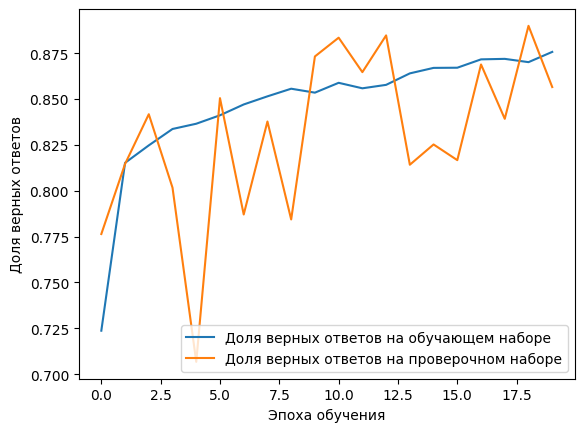

In [112]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [97]:
best_model = load_model('../models/ltsm_twitter/')

In [99]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

150/150 [==============================] - 4s 24ms/step


In [122]:
list(test_df['tweet'])[11], test_predictions[11], y_test[11]

('#dailyaffirmation i do not #exist to #impress the world i exist to #live my #life in a way that will make me   ',
 array([0]),
 0)

In [101]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      4454
           1       0.38      0.81      0.52       341

    accuracy                           0.89      4795
   macro avg       0.68      0.85      0.73      4795
weighted avg       0.94      0.89      0.91      4795



In [103]:
model.evaluate(X_test, y_test, verbose=1)

150/150 [==============================] - 3s 23ms/step - loss: 0.2830 - accuracy: 0.8747 - auc: 0.9344


[0.28304627537727356, 0.8746610879898071, 0.9343738555908203]